In [78]:
import mlflow
import numpy as np
import pandas as pd
import csv
from datetime import datetime
import seaborn as sns
import logging
import mlflow
from pandas import DataFrame, concat
from tqdm import tqdm as tqdm_progress
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from dataclay import Client
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

import sys
sys.path.insert(0,'/home/jaydeep/UCD_FUN_HORIZON_ICOS/src/icos_api/') 

In [79]:
from utils.utils import *

In [80]:
raw_data = pd.read_csv("../dataset/cpu_data_custom.csv")

In [81]:
raw_data_clean = data_clean(raw_data)
train_df, test_df = data_simple_split(raw_data_clean,test_size=0.2)

In [82]:
train_df.head()

date  TARGET   RAM
34992  2023-07-23 19:40:00    57.8  14.3
33738  2023-07-22 22:03:05    25.0  14.3
12662  2023-07-07 18:46:12    85.1  12.9
37591  2023-07-25 16:27:52    73.8  14.3
32654  2023-07-22 03:22:01     0.4  14.1

In [83]:
supervised_train_data = series_to_supervised(train_df[["TARGET"]], n_in=12, n_out=1)
supervised_test_data = series_to_supervised(test_df[["TARGET"]], n_in=12, n_out=1 )

In [84]:
supervised_train_data.head()

var1(t-12)  var1(t-11)  var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  \
34890        57.8        25.0        85.1       73.8        0.4       79.5   
19573        25.0        85.1        73.8        0.4       79.5        0.1   
30662        85.1        73.8         0.4       79.5        0.1       52.7   
29027        73.8         0.4        79.5        0.1       52.7       94.8   
43542         0.4        79.5         0.1       52.7       94.8        0.1   

       var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  \
34890        0.1       52.7       94.8        0.1       99.1       71.4   
19573       52.7       94.8        0.1       99.1       71.4        8.6   
30662       94.8        0.1       99.1       71.4        8.6       95.0   
29027        0.1       99.1       71.4        8.6       95.0       58.1   
43542       99.1       71.4        8.6       95.0       58.1       56.9   

       var1(t)  
34890      8.6  
19573     95.0  
30662     58.1  
29027     56.9  
43542     36.2

In [89]:
X_train = supervised_train_data.iloc[:,:-1]
y_train = supervised_train_data.iloc[:,-1]
X_test = supervised_test_data.iloc[:,:-1]
y_test = supervised_test_data.iloc[:,-1]

In [91]:
# Performs normalisation separately on input and output
def normalize_data(X_train, X_test, y_train, y_test):
    # Convert input data to pandas Series if they are not
    if not isinstance(X_train, pd.DataFrame):
        X_train = pd.DataFrame(X_train, columns=X_test.columns if isinstance(X_test, pd.DataFrame) else None)
    if not isinstance(X_test, pd.DataFrame):
        X_test = pd.DataFrame(X_test, columns=X_train.columns if isinstance(X_train, pd.DataFrame) else None)
    if not isinstance(y_train, pd.Series):
        y_train = pd.Series(y_train, name=y_test.name if isinstance(y_test, pd.Series) else None)
    if not isinstance(y_test, pd.Series):
        y_test = pd.Series(y_test, name=y_train.name if isinstance(y_train, pd.Series) else None)

    # Normalize X data
    scaler_X = StandardScaler()
    scaler_X.fit(X_train)
    X_train_normalized = pd.DataFrame(scaler_X.transform(X_train), columns=X_train.columns)
    X_test_normalized = pd.DataFrame(scaler_X.transform(X_test), columns=X_test.columns)

    # Normalize y data
    scaler_y = StandardScaler()
    scaler_y.fit(y_train.values.reshape(-1, 1))
    y_train_normalized = pd.Series(scaler_y.transform(y_train.values.reshape(-1, 1)).flatten(), name=y_train.name)
    y_test_normalized = pd.Series(scaler_y.transform(y_test.values.reshape(-1, 1)).flatten(), name=y_test.name)

    return X_train_normalized, X_test_normalized, y_train_normalized, y_test_normalized, scaler_y

In [92]:
# Normalize data
X_train_normalized, X_test_normalized, y_train_normalized, y_test_normalized, scaler_y = normalize_data(X_train, X_test, y_train, y_test)

In [137]:
model = XGBRegressor()
model.fit(X_train_normalized, y_train_normalized)
y_pred = model.predict(X_test_normalized)
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1,1))
y_test = np.array(y_test_normalized).reshape(-1,1)

2024/05/16 17:39:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd106f2f4378140f48a8cf3765831da7c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2024/05/16 17:40:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/jaydeep/anaconda3/envs/book/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:40:03] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."
2024/05/16 17:40:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/jaydeep/anaconda3/envs/book/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


In [138]:
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [139]:
metrics = {}
metrics['mse'] = mean_squared_error(y_test, y_pred)
metrics['rmse'] = np.sqrt(mean_squared_error(y_test, y_pred))
metrics['mape'] = mean_absolute_percentage_error(y_test, y_pred)
metrics['mae'] = round(mean_absolute_error(y_test, y_pred), 2)
metrics['smape'] = round(symmetric_mean_absolute_percentage_error(y_test, y_pred), 2)
metrics['r2'] = r2_score(y_test, y_pred)
metrics

{'mse': 2657.907568915526,
 'rmse': 51.55489859281585,
 'mape': 264.1967604138016,
 'mae': 50.94,
 'smape': 196.59,
 'r2': -2657.753601391297}

In [108]:
import mlflow
from mlflow import MlflowClient

In [142]:
model.predict(X_test_normalized)

array([ 0.15158623, -0.06242617,  0.33809215, ..., -0.09212018,
       -0.01089251,  0.25399724], dtype=float32)

In [143]:
!pip install shap

  Using cached numba-0.59.1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.7 kB)
  Using cached llvmlite-0.42.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 54.0 MB/s eta 0:00:00
Using cached numba-0.59.1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.7 MB)
Using cached llvmlite-0.42.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (43.8 MB)


In [144]:
import shap

https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137 

In [145]:
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test_normalized)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test_normalized)

PermutationExplainer explainer: 9452it [1:04:01,  2.46it/s]                                                                                                                                                                                                                     


In [160]:
np.shape(shap_values.values)

(9451, 12)

#### Plot a global summary

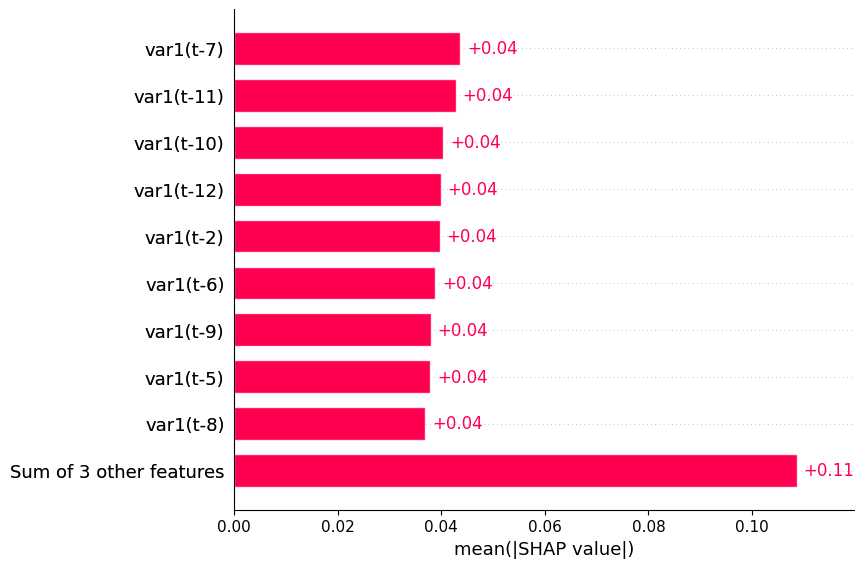

In [146]:
shap.plots.bar(shap_values)

#### Masking values

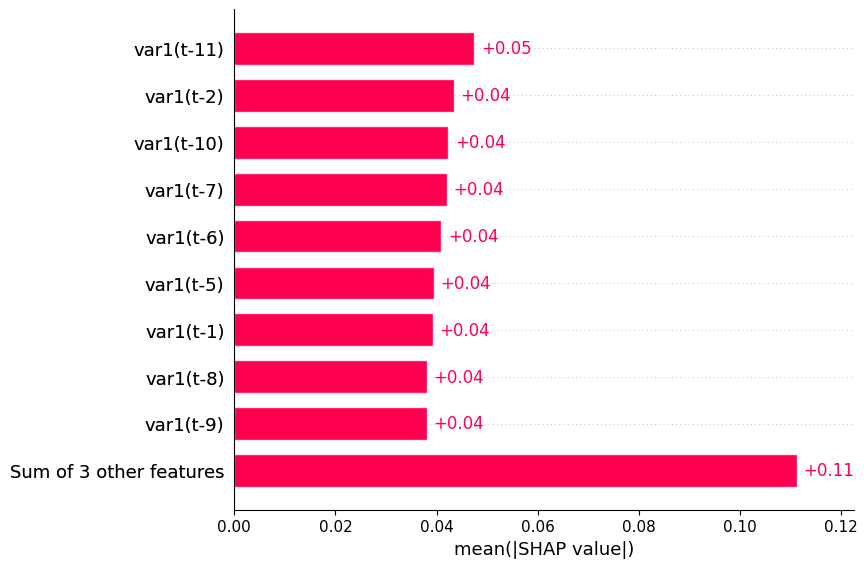

In [156]:
shap.plots.bar(shap_values[:500])

#### Plot a single instance

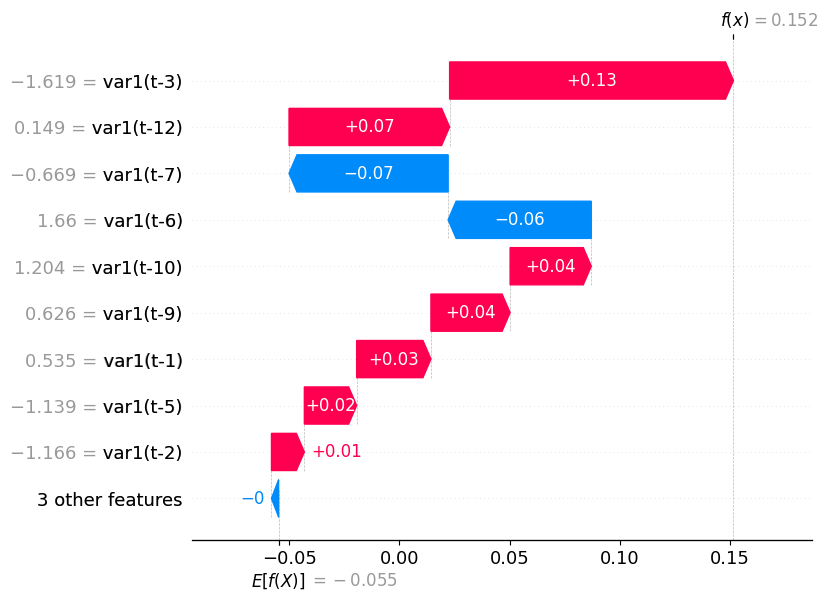

In [153]:
shap.plots.waterfall(shap_values[0])

#### Plot heatmap

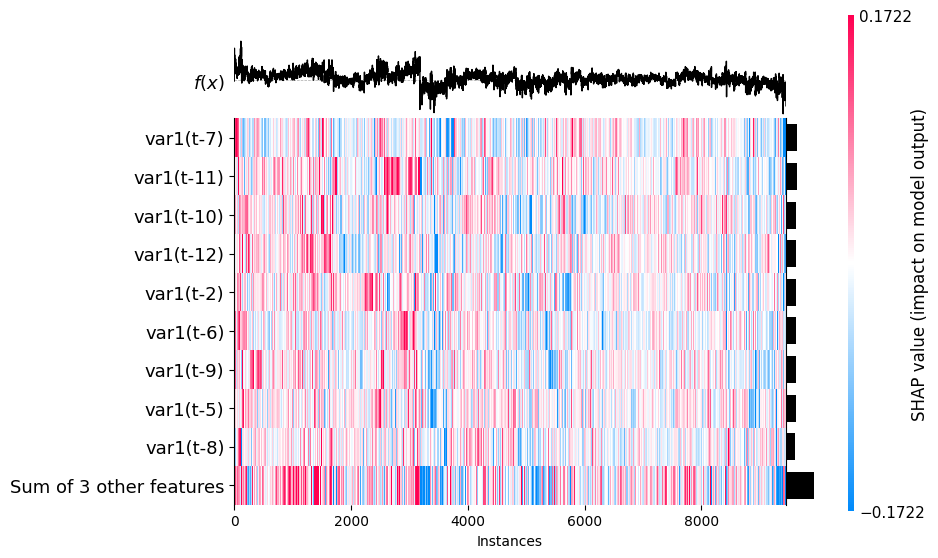

<Axes: xlabel='Instances'>

In [155]:
shap.plots.heatmap(shap_values)

In [162]:
shap.initjs()

In [167]:
shap.plots.force(shap_values[0])

In [169]:
shap.plots.force(shap_values[0:100])

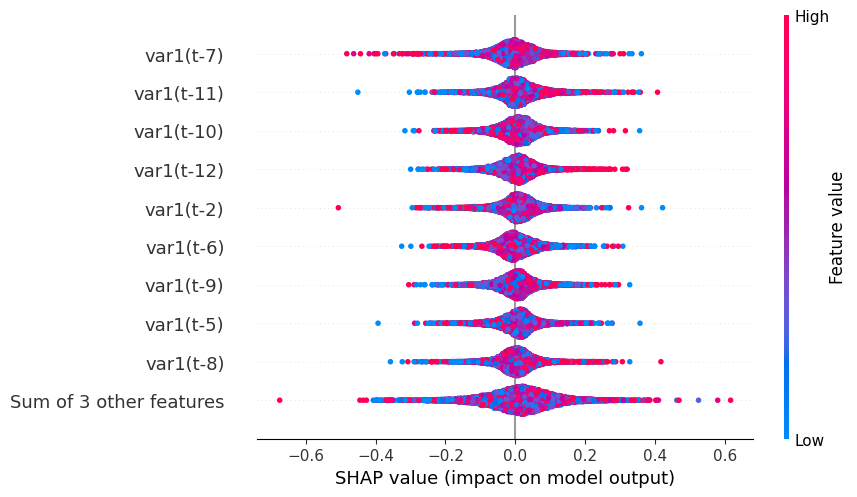

In [170]:
shap.plots.beeswarm(shap_values)

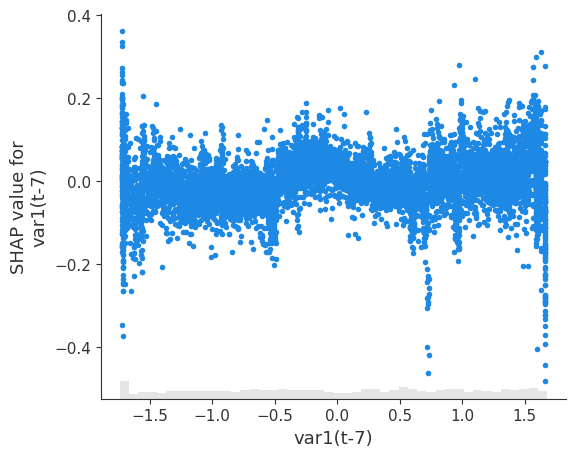

In [175]:
shap.plots.scatter(shap_values[:,"var1(t-7)"])

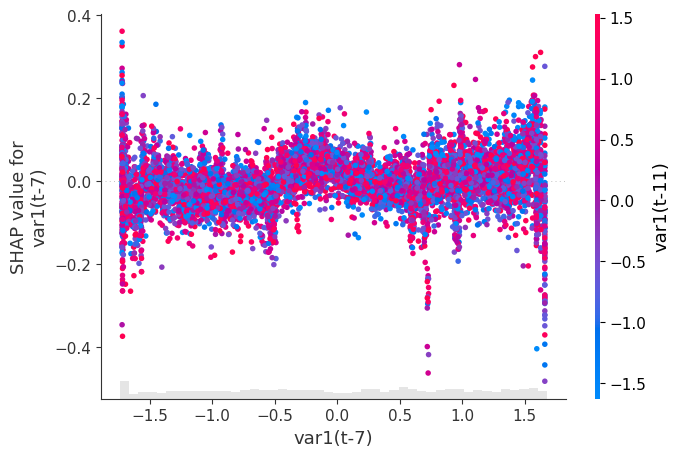

In [176]:
shap.plots.scatter(shap_values[:,"var1(t-7)"],
                  color=shap_values[:,"var1(t-11)"])

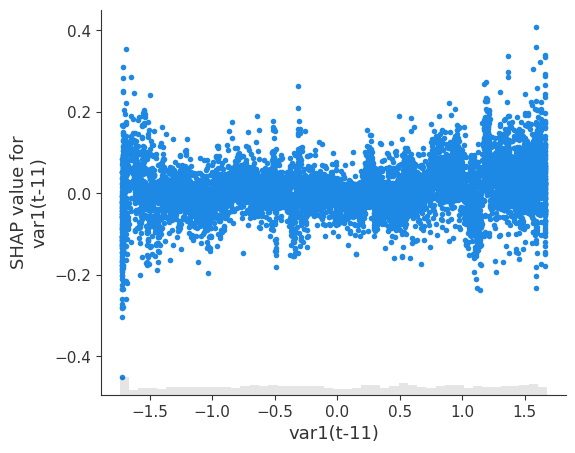

In [178]:
shap.plots.scatter(shap_values[:,"var1(t-11)"])

#### Without normalisation

In [179]:
supervised_train_data.head()

var1(t-12)  var1(t-11)  var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  \
34890        57.8        25.0        85.1       73.8        0.4       79.5   
19573        25.0        85.1        73.8        0.4       79.5        0.1   
30662        85.1        73.8         0.4       79.5        0.1       52.7   
29027        73.8         0.4        79.5        0.1       52.7       94.8   
43542         0.4        79.5         0.1       52.7       94.8        0.1   

       var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  \
34890        0.1       52.7       94.8        0.1       99.1       71.4   
19573       52.7       94.8        0.1       99.1       71.4        8.6   
30662       94.8        0.1       99.1       71.4        8.6       95.0   
29027        0.1       99.1       71.4        8.6       95.0       58.1   
43542       99.1       71.4        8.6       95.0       58.1       56.9   

       var1(t)  
34890      8.6  
19573     95.0  
30662     58.1  
29027     56.9  
43542     36.2

In [180]:
X_train = supervised_train_data.iloc[:,:-1]
y_train = supervised_train_data.iloc[:,-1]
X_test = supervised_test_data.iloc[:,:-1]
y_test = supervised_test_data.iloc[:,-1]

In [186]:
n_samples = 600

In [190]:
model2 = XGBRegressor()
model2.fit(X_train[:n_samples], y_train[:n_samples])
y_pred = model2.predict(X_test[:n_samples])

2024/05/17 16:03:10 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '69299677bba74dcf96b6f8e0b1adf804', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2024/05/17 16:03:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/jaydeep/anaconda3/envs/book/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:03:47] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."


In [191]:
model2

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Text(0.5, 0, 'Samples')

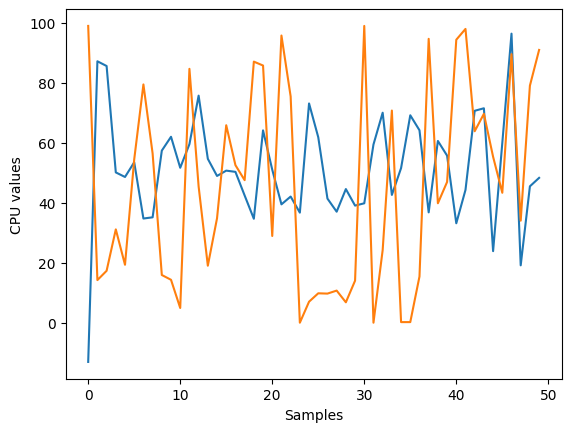

In [209]:
import matplotlib.pyplot as plt
plt.plot(y_pred[:50])
plt.plot(y_test[:50])
plt.ylabel("CPU values")
plt.xlabel("Samples")